# Projet Machine Learning et IoT: un exercice de Géolocalisation
ALI Mohammad Fayyaz  
AOUANI El-Habib  
LEGRAND Romain  

### Imports

In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn.linear_model import LinearRegression
import folium

### un premier aperçu des données

In [14]:
# chargement de l'échantillon train
mess_train = pd.read_csv('mess_train_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')
print('La dimension de mess_train est', mess_train.shape)
print('La dimension de pos_train est', pos_train.shape)
# concatenation des dataframe mess_train et pos_train
train = pd.concat([mess_train, pos_train],axis = 1)
print('La dimension de train est', train.shape)
# chargement de l'échantillon test
mess_test = pd.read_csv('mess_test_list.csv')
print('La dimension de mess_test est', mess_test.shape)
test = mess_test
# on ajoute des colonnes de zeros pour les variables lat et lng dans test (pour pouvoir reunir train et test)
test['lat'] = 0
test['lng'] = 0
# on fait la concatenation des échantillons train et test (on les séparera à nouveau plus tard)
train_test = pd.concat([train, test],axis = 0)
print('La dimension de train_test est', train_test.shape)

La dimension de mess_train est (39250, 8)
La dimension de pos_train est (39250, 2)
La dimension de train est (39250, 10)
La dimension de mess_test est (29286, 8)
La dimension de train_test est (68536, 10)


In [15]:
train.head()

messid  bsid       did  nseq   rssi       time_ux  \
0  573bf1d9864fce1a9af8c5c9  2841  473335.0   0.5 -121.5  1.463546e+12   
1  573bf1d9864fce1a9af8c5c9  3526  473335.0   2.0 -125.0  1.463546e+12   
2  573bf3533e952e19126b256a  2605  473335.0   1.0 -134.0  1.463547e+12   
3  573c0cd0f0fe6e735a699b93  2610  473953.0   2.0 -132.0  1.463553e+12   
4  573c0cd0f0fe6e735a699b93  3574  473953.0   1.0 -120.0  1.463553e+12   

      bs_lat      bs_lng        lat         lng  
0  39.617794 -104.954917  39.606690 -104.958490  
1  39.677251 -104.952721  39.606690 -104.958490  
2  39.612745 -105.008827  39.637741 -104.958554  
3  39.797969 -105.073460  39.730417 -104.968940  
4  39.723151 -104.956216  39.730417 -104.968940

In [16]:
test.groupby('messid').count().shape[0]

5294

De manière générale, les informations cruciales dans les tables de message semblent être les features 'rssi', qui reflètent la puissance de réception du signal, et les variables bs_lat et bs_lng qui fournissent la géolocalisation des stations.

In [17]:
# pour la suite des analyses: on commence par dresser une liste de tous les messid du train
messid_train = np.unique(train['messid'])
# on fait ensuite la liste de tous les messid du test
messid_test = np.unique(test['messid'])
# on regarde si il y a des messages communs aux deux listes: normalement non!
common_id = np.intersect1d(messid_train, messid_test)
print("il y a " + str(common_id.shape[0]) + " messid en commun entre les échantillons train et test.")

il y a 0 messid en commun entre les échantillons train et test.


### Localisation des stations

Le but de cette partie du projet est d'identifier les stations réceptrices des signaux émis par les device. En effet, ces stations représentent l'input principal pour déterminer la position du device émetteur. Il convient donc de s'assurer en premier lieu que les données liées à ces stations sont propres et ne contiennent pas de valeurs manquantes ou d'outliers. On commence par regarder les colonnes bsid, bs_lat et bs_lng.

In [18]:
nb_nan_bsid = train_test['bsid'].isnull().sum()
print("Il y a " + str(nb_nan_bsid) + " valeurs manquantes dans la colonne bsid.")
nb_nan_bs_lat = train_test['bs_lat'].isnull().sum()
print("Il y a " + str(nb_nan_bs_lat) + " valeurs manquantes dans la colonne bs_lat.")
nb_nan_bs_lng = train_test['bs_lng'].isnull().sum()
print("Il y a " + str(nb_nan_bs_lng) + " valeurs manquantes dans la colonne bs_lng.")

Il y a 0 valeurs manquantes dans la colonne bsid.
Il y a 0 valeurs manquantes dans la colonne bs_lat.
Il y a 0 valeurs manquantes dans la colonne bs_lng.


In [9]:
# on crée une liste des coordonnées de l'ensemble des stations
loc = train_test[['messid','bsid','bs_lat', 'bs_lng']]
temp1 = loc[loc['messid'].isin(messid_train)]
loc_train_list = temp1.drop(columns=['bsid','messid']).drop_duplicates().values.tolist()
# on crée une liste des coordonnées des stations test
temp2 = loc[loc['messid'].isin(messid_test)]
loc_test_list = temp2.drop(columns=['bsid','messid']).drop_duplicates().values.tolist()
# on visualise l'emplacement des stations (bleu pour train, rouge pour test)
map = folium.Map(location=[52, -94], zoom_start=3.5)
for point in range(0, len(loc_train_list)):
    folium.CircleMarker(loc_train_list[point], popup=temp1['bsid'][point], radius=2,color='blue').add_to(map)
for point in range(0, len(loc_test_list)):
    folium.CircleMarker(loc_test_list[point], popup=temp2['bsid'][point], radius=2,color='red').add_to(map)
map

On cherche ensuite à visualiser les stations: bleu pour l'échantillon train, rouge pour l'échantillon test.

Nous allons regarder le nombre de stations qui apparaissent uniquement dans l'échantillon test:

In [19]:
stations_pas_train = pd.DataFrame(columns=['bs_lat','bs_lng'])
i = 0
for row in pd.unique(test['bs_lat'].astype(str)+' '+test['bs_lng'].astype(str)):
    if row in pd.unique(train['bs_lat'].astype(str)+' '+train['bs_lng'].astype(str)):
        0
    else:
        stations_pas_train.loc[i,:] = row.split(' ')
        i = i+1
        
stations_pas_train

bs_lat               bs_lng
0       41.8273960567       -106.833116963
1       41.8438433443       -106.810147946
2       36.7850875923  -102.73742581299999
3  48.072889483599994  -110.95718139899999
4       41.7055082088  -106.86328878799999
5       39.8797578665        -105.19856183

In [20]:
liste_nombre = []
for row in pd.unique(stations_pas_train['bs_lat'].astype(str)+' '+stations_pas_train['bs_lng'].astype(str)):
    liste_nombre.append(test[row == test['bs_lat'].astype(str)+' '+test['bs_lng'].astype(str)].shape[0])

In [21]:
stations_pas_train['nombre messid'] = liste_nombre
print('nombre de messages tests avec une station pas le train:', stations_pas_train['nombre messid'].sum())
stations_pas_train

nombre de messages tests avec une station pas le train: 33


bs_lat               bs_lng  nombre messid
0       41.8273960567       -106.833116963              2
1       41.8438433443       -106.810147946              2
2       36.7850875923  -102.73742581299999             22
3  48.072889483599994  -110.95718139899999              4
4       41.7055082088  -106.86328878799999              1
5       39.8797578665        -105.19856183              2

### Traitement de l'outlier du Nunavut

Les observations de stations attribuées au Nunavut canadien sont problématiques car elles faussent entièrement le jeu de données. Voyons d'abord si ces observations sont marginales:

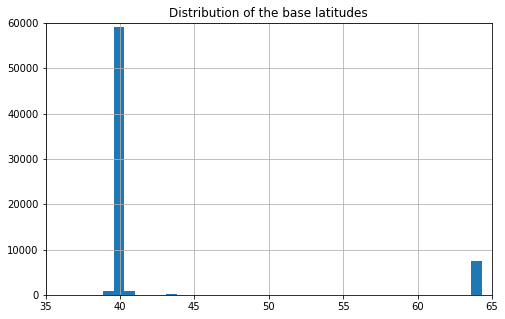

In [22]:
fig_1 = plt.figure(figsize=(8,5))
plt.hist(train_test['bs_lat'], bins = 40)
plt.xlim([35, 65])
plt.ylim([0, 60000])
plt.title('Distribution of the base latitudes')
plt.grid(True)
plt.show()

Les observations en question sont facilement détectées: ce sont celles qui ontune lattitude extrême, autour de 65. On peut voir que ces observations sont loin d'être marginales. Elles couvrent environ 8000 observations sur un total de 68000, soit 12% de l'échantillon total. Il ne paraît alors pas adapté de les supprimer, et il convient de trouver une solution.

Il faut pour commencer se poser deux questions:
- le point identifié correspond-il à une seule ou à plusieurs géolocalisations? 
- le point identifié correspond-il à une seule ou à plusieurs bs_id? En effet, on peut imaginer que même sur une géolocalisation unique, plusieurs id de stations soient associés à ce point.

On va vérifier les deux points.

In [23]:
# on vérifie si l'outlier concerne une seule ou plusieurs stations
temp3 = train_test[train_test['bs_lat']>60]
nb_bs = np.unique(temp3[['bs_lat', 'bs_lng']])
nb_bs

array([-68.5,  64.3])

Le point correspond à un seul couple de coordonnées: il coorespond donc à une seule station au Nunavut.

In [24]:
# on vérifie si l'outlier concerne une seule ou plusieurs bs_id
bs_list = np.unique(temp3['bsid'])
print("La station outlier représente " + str(bs_list.shape[0]) + " stations différentes.")
bs_list

La station outlier représente 29 stations différentes.


array([ 1092,  1594,  1661,  1743,  1772,  1796,  1854,  2293,  2707,
        2943,  4123,  4129,  4156,  4959,  4987,  4993,  7248,  8355,
        8449,  8451,  8560,  9784,  9941,  9949, 10151, 10162, 10999,
       11007, 11951])

On arrive à la conclusion suivante: un certain nombre de stations de l'échantillon (29) se sont vues attribuer à tort une localisation vraissemblablement fantaisiste au Nunavut. Pour vérifier cela, on va représenter la localisation des devices dont les messages ont été captés par ces stations, et on va voir si les device en question se trouvaient près de Denver, ou au fin fonds du Canada. Cela n'est possible que pour l'échantillon train, pour lequel la localisation réelle des device est connue.

In [25]:
# on restreint à l'échantillon train
temp4 = train_test[train_test['messid'].isin(messid_train)]
# on retient les stations au Nunavut, et ne garde que les coordonnées des devices
temp4 = temp4[temp4['bs_lat']>60][['lat', 'lng']].drop_duplicates()
# création d'une liste de coordonnées des devices
temp4 = temp4.values.tolist()
# on visualise l'emplacement des stations
map = folium.Map(location=[41, -105], zoom_start=6)
for point in range(0, len(temp4)):
    folium.CircleMarker(temp4[point], radius=2,color='blue').add_to(map)
map

L'intégralité des device sont donc situés dans la région de Denver, avec quelques outliers dans le Wyoming. Il est donc établi que ces device ne peuvent pas avoir été captés par des stations au Nunavut, et que la localisation indiquée est erronée. 

Il s'agit ensuite de reconstituer une localisation approximative des stations erronées. Pour les stations présentes dans l'échantillon test, on peut assez facilement faire une approximation en prenant le barycentre des localisations des devices qui l'ont atteinte. Si certaines stations ne sont présentes que dans l'échantillon test, toutefois, cette option ne sera pas disponible car on ne dispose par définition pas de la localisation réelle des devices. Dans ces cas là, on n'aura pas d'autre choix que de prendre le barycentre global des device identifiés dans l'échantillon train.

In [26]:
# on identifie d'abord les stations de l'échantillon train
temp5 = train[train['bs_lat']>60]
temp5 = np.unique(temp5['bsid'])
# on identifie ensuite les stations de l'échantillon test
temp6 = test[test['bs_lat']>60]
temp6 = np.unique(temp6['bsid'])
# on identifie les stations de l'échantillon test non présentes dans le train
temp7 = temp6[~np.isin(temp6, temp5)]
print("Il y a en tout " + str(bs_list.shape[0]) + " stations localisées à tort dans le Nunavut.")
print("Sur ces stations, " + str(temp5.shape[0]) + " apparaissent dans l'échantillon train, et " +\
      str(temp7.shape[0]) + " apparaissent uniquement dans l'échantillon test.")

Il y a en tout 29 stations localisées à tort dans le Nunavut.
Sur ces stations, 27 apparaissent dans l'échantillon train, et 2 apparaissent uniquement dans l'échantillon test.


Pour les 27 stations présentes dans le train, on va créer une pseudo géolocalisation de la station en prenant le barycentre de tous les devices qui ont atteint cette station.

In [27]:
# boucle sur les stations erronnées de l'échantillon train
for id in temp5:
    temp8 = train_test[train_test['bsid']==id].copy()
    temp9 = train_test[train_test['bsid']!=id].copy()
    # lattitude et longitude moyennes des device sur cette station
    median_lat = train[train['bsid']==id]['lat'].median()
    median_lng = train[train['bsid']==id]['lng'].median()
    # on modifie les lattitude et longitude de la station
    temp8.loc[:, 'bs_lat'] = median_lat
    temp8.loc[:, 'bs_lng'] = median_lng
    # on reconstitue train_test
    train_test = pd.concat([temp8, temp9],axis = 0)

Pour les deux stations présentes dans le test uniquement, on va créer une pseudo géolocalisation de la station en prenant le barycentre de tous les devices qui avaient atteint la station erronnée.

In [28]:
# restriction du dataset aux device qui avaient atteint la station erronée
temp10 = train[train['bsid'].isin(temp5)]
# calcul des coordonnées médianes
median_lat = temp10[['lat']].median().values
median_lng = temp10[['lng']].median().values
# boucle sur les stations erronnées de l'échantillon test
for id in temp7:
    # on sépare la station concernée du reste du dataset
    temp11 = train_test[train_test['bsid']==id].copy()
    temp12 = train_test[train_test['bsid']!=id].copy()
    # on modifie les lattitude et longitude de la station
    temp11.loc[:, 'bs_lat'] = median_lat
    temp11.loc[:, 'bs_lng'] = median_lng
    # on reconstitue train_test
    train_test = pd.concat([temp11, temp12],axis = 0)

On vérifie maintenant que les corrections ont réglé le problème. On commence par refaire un graphique des lattitudes des stations:

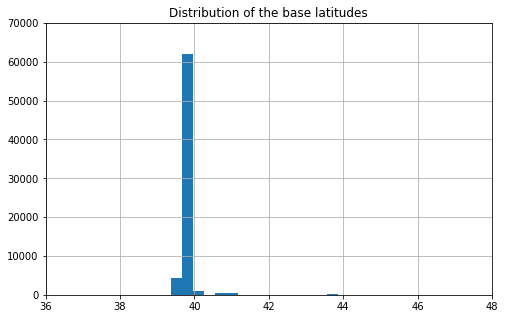

In [29]:
fig_2 = plt.figure(figsize=(8,5))
plt.hist(train_test['bs_lat'], bins = 40)
plt.xlim([36, 48])
plt.ylim([0, 70000])
plt.title('Distribution of the base latitudes')
plt.grid(True)
plt.show()

On voit que les lattitudes sont maintenant réparties correctement, à proximité de la valeur 40. Il n'y a plus d'outliers. On peut aussi dresser à nouveau une carte des géolocalisations des stations:

On voit que les stations au Nunavut ont disparu, et que toutes les stations ont désormais une répartition raisonnable dans la région de Denver.

### Traitement des outliers du Dakota du Sud

Comme on a pu le voir sur la première carte, l'échantillon train présente quelques outliers dans le Dakota du Sud. On va commencer par dénombrer ces outliers. Ils correspondent aux points de latitude supérieure à 42 et de longitude supérieure à -105.

In [30]:
temp14 = train_test[(train_test['bs_lng']>-105) & (train_test['bs_lat']>42)]
temp15 = temp14['bsid'].drop_duplicates().values.tolist()
print("Il y a " + str(temp14.shape[0]) + " outliers dans le Dakota du Sud, répartis sur " + str(len(temp15)) + " stations.")

Il y a 178 outliers dans le Dakota du Sud, répartis sur 10 stations.


On a donc 178 des outliers. Sur 40000 données de l'échantillon train, ils représentent peu d'information. Etant donné qu'ils apportent peu d'information mais sont très différents des autres points, on préfèrera les enlever de l'échantillon. On vérifie ensuite que les stations ont bel et bien disparu.

In [31]:
train_test = train_test[(train_test['bs_lng']<=-105) | (train_test['bs_lat']<=42)].copy()

### Traitement des stations dupliquées

Un autre problème qui peut se poser est celui des stations en doublon: certaines stations peuvent avoir un id différent mais correspondre en réalité à une seule et même station, ce qui sera vérifié par le fait qu'elles partagrnt exzctement la même géolocalisation.

In [32]:
# on commence par faire une liste de toutes les stations avec leur id, latitude et longitude
bs = train_test[['bsid','bs_lat', 'bs_lng']].drop_duplicates()
bs.head()
# on vérifie le nombre d'id uniques
nb_id = np.unique(bs['bsid']).shape[0]
# on vérifie le nombre de couples latitudes/longitudes uniques
nb_bs = bs[['bs_lat','bs_lng']].drop_duplicates().shape[0]
print('Il y a ' + str(nb_id) + ' id uniques et ' + str(nb_bs) + ' couples uniques de latitude/longitude.')
print('Autrement dit, il y a ' + str(nb_id - nb_bs) + ' stations qui ont des id différents mais sont en réalité la même station.')

Il y a 249 id uniques et 243 couples uniques de latitude/longitude.
Autrement dit, il y a 6 stations qui ont des id différents mais sont en réalité la même station.


On peut facilement voir ces stations duppliquées en faisant un GroupBy sur latitude et longitude:

In [33]:
pd.concat(g for _, g in bs.groupby('bs_lat') if len(g) > 1)

bsid     bs_lat      bs_lng
2723    8453  39.680252 -104.925515
2724    8457  39.680252 -104.925515
94      8370  39.706436 -105.099323
294     8364  39.706436 -105.099323
2180    8747  39.730087 -104.919391
3340    8351  39.730087 -104.919391
49      8437  39.759461 -105.074287
92      8245  39.759461 -105.074287
13431   9949  39.773364 -105.028769
14668   9941  39.773364 -105.028769
14342  10999  39.776925 -105.018648
14306   4959  39.776925 -105.018648

On voit que par exemple les stations 8453 et 8457 ont un id différent mais ont exactement la même localisation. C'est un problème, car si on entre ces stations comme des stations différentes, on aura des problèmes de multi-colinéarité.

In [34]:
# on va donc recréer une nouvelle série d'id qui évitera les duplications de stations
train_test['new_bsid'] = train_test.groupby(['bs_lat','bs_lng']).ngroup() + 1
# on drop les id de stations dupliquées
train_test = train_test.drop(columns=['bsid']).sort_values(by=['new_bsid'])
# on compte le nombre d'id de stations après èlimination des duplicats
nb_bs = np.unique(train_test['new_bsid']).shape[0]
# affichage
print('Il y avait ' + str(nb_id) + ' bsid; après élimination des doublons, il reste ' + str(nb_bs) + ' new_bsid.')
train_test.head()

Il y avait 249 bsid; après élimination des doublons, il reste 243 new_bsid.


messid       did  nseq        rssi       time_ux  \
9711   57849df012f143318207f0b7  476212.0   1.5 -138.000000  1.468309e+12   
19229  57cf9249cf554f22dcd6e486  476835.0   1.0 -125.000000  1.473221e+12   
19234  57cf9a1c12f1437531fda9c8  476835.0   1.0 -130.666667  1.473223e+12   
19231  57cf977be541cd01b3cc66bd  476835.0   1.0 -130.333333  1.473223e+12   
19230  57cf94df12f1437531fa1871  476835.0   1.0 -127.666667  1.473222e+12   

          bs_lat      bs_lng        lat         lng  new_bsid  
9711   36.053394 -102.011461  35.770683 -102.094289         1  
19229  36.187012 -102.208966  36.089562 -102.313746         2  
19234  36.187012 -102.208966  36.064303 -102.278110         2  
19231  36.187012 -102.208966  36.072726 -102.286895         2  
19230  36.187012 -102.208966  36.079944 -102.298687         2

### Calcul de la distance entre appareil et station, et estimation du modèle distance-loss

On dispose pour chaque observation du rssi, c'est-à-dire de la force de réception du signal émis par le device. Il existe une relation approximative entre le rssi et la distance qui sépare le device de la station de réception. Or, cette distance est une information extrêmement utile pour prédire la géolocalisation d'un device. On va donc essayer d'estimer cette relation, connue sous le nom de modèle distance-loss, en utilisant les données disponibles. Plus précisément, on peut calculer pour l'échantillon train la distance exacte entre les devices et le stations puisqu'on dispose des géolocalisations des deux. A partir de là, on peut estimer notre modèle distance-loss et l'utiliser ensuite sur l'échantillon test pour prédire une distance à partir du rssi, en espérant que cette distance soit précisément estimée.

On va commencer par calculer la distance entre les device et les stations pour l'échantillon train.

In [35]:
# on se restreint à l'échantillon train
temp14 = train_test[train_test['messid'].isin(messid_train)].copy()
# calcul de la distance
temp14['dist'] = temp14.apply(lambda x: geodesic((x['lat'], x['lng']), (x['bs_lat'], x['bs_lng'])).km, axis = 1)

In [36]:
temp14

messid       did  nseq        rssi       time_ux  \
9711   57849df012f143318207f0b7  476212.0   1.5 -138.000000  1.468309e+12   
19229  57cf9249cf554f22dcd6e486  476835.0   1.0 -125.000000  1.473221e+12   
19234  57cf9a1c12f1437531fda9c8  476835.0   1.0 -130.666667  1.473223e+12   
19231  57cf977be541cd01b3cc66bd  476835.0   1.0 -130.333333  1.473223e+12   
19230  57cf94df12f1437531fa1871  476835.0   1.0 -127.666667  1.473222e+12   
...                         ...       ...   ...         ...           ...   
28704  5822e1b212f1434b9c16410d  474192.0   1.0 -139.000000  1.478681e+12   
28702  5822df26cf554f7e3aa2e56e  474192.0   2.0 -137.000000  1.478680e+12   
12296  579f6112cf554f465af6e59a  473902.0   1.0 -139.000000  1.470063e+12   
12301  579f757012f14345916d4bc2  473902.0   1.0 -132.666667  1.470068e+12   
12302  579f76db12f14345916e5154  473902.0   1.0 -135.666667  1.470068e+12   

          bs_lat      bs_lng        lat         lng  new_bsid       dist  
9711   36.053394 -102.011461  35.770683 -102.094289         1  32.247480  
19229  36.187012 -102.208966  36.089562 -102.313746         2  14.347998  
19234  36.187012 -102.208966  36.064303 -102.278110         2  14.971162  
19231  36.187012 -102.208966  36.072726 -102.286895         2  14.492155  
19230  36.187012 -102.208966  36.079944 -102.298687         2  14.365341  
...          ...         ...        ...         ...       ...        ...  
28704  42.398650 -107.066221  42.398650 -107.066221       240   0.000000  
28702  42.452279 -107.050011  42.452279 -107.050011       241   0.000000  
12296  42.850670 -107.463146  43.138854 -107.630679       242  34.808324  
12301  42.850670 -107.463146  43.140387 -107.629913       242  34.940516  
12302  42.850670 -107.463146  43.139786 -107.629761       242  34.874238  

[39072 rows x 11 columns]

Une fois les distances connues, on peut essayer d'estimer la relation entre la distance et le rssi. Le modèle classique de la littérature est le modèle dit de 'logarithmic distance path-loss'. Li et al. (Li, G. and Geng, E. and Ye, Z. and Xu, Y. and Lin, J. and Pang, Y. (2018): "Indoor positioning algorithm based on the improved RSSI distance model", Sensors, 18(9)) proposent la version suivante du modèle:

$RSSI = -10 \ \eta \ log_{10}(d)+ A + X_\sigma$

Dans le modèle, $d$ désigne la distance entre l'appareil émetteur et le récepteur, et $A$ une constante qui reflète le RSSI moyen lorsque l'appareil émetteur est placé à une unité de distance du récepteur. $X_\sigma$ une variable aléatoire gaussienne de moyenne 0 et de variance $\sigma^2$ qui reflète le bruit du modèle. $\eta$ est un paramètre de "path-loss" qui reflète les spécificités de l'environnement dans lequel l'émission a lieu. C'est ce paramètre qui est inconnu et qui nous intéresse pour pouvoir utiliser le modèle. On peut simplifier la formulation du modèle:

$RSSI = \eta \ ld + A + X_\sigma$

avec $ld = -10 \ log_{10}(d)$. $ld$ étant la négative du log, il représente une mesure de l'inverse de la distance, ce qui peut être interprêté comme une mesure de proximité entre le device et sa station réceptrice. Autrement dit, plus la valeur de $ld$ est élevée, plus le device est proche de la station. on peut alors raisonner en termes de proximité et reformuler le modèle comme suit:

$ld = \frac{1}{\eta} RSSI - \frac{A}{\eta} - \frac{1}{\eta} X_\sigma $

ou, de façon équivalente:

$ld = \gamma RSSI + C + \tilde{X}_\sigma$

On attends une relation croissante entre $ld$ et $RSSI$, ce qu'on va vérifier par scatterplot.

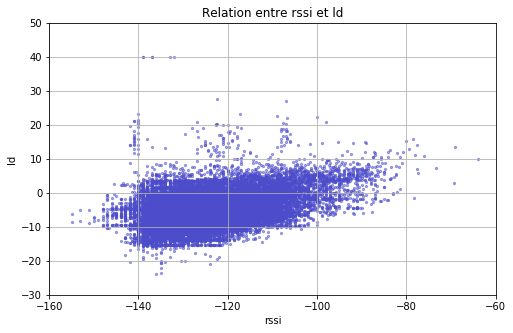

In [37]:
# création de la nouvelle série
temp14['ld'] = -10 * np.log10(temp14['dist']+0.0001)
# scatterplot pour visualiser la relation
fig_3 = plt.figure(figsize=(8,5))
plt.scatter(temp14['rssi'], temp14['ld'], c=[[0.3,0.3,0.8]], alpha=0.5, s=5);
plt.xlim([-160, -60])
plt.xlabel("rssi")
plt.ylim([-30, 50])
plt.ylabel("ld")
plt.title('Relation entre rssi et ld')
plt.grid(True)
plt.show()

On observe qu'il semble bien y avoir une relation linéaire, croissante, entre l'intensité du signal rssi et la proximité ld. On peut estimer cette relation par OLS:

In [38]:
# conversion des variables en numpy pour la régression
ld = temp14['ld'].to_numpy().reshape(-1, 1)
rssi = temp14['rssi'].to_numpy().reshape(-1, 1)
# estimation du modèle linéaire
lr = LinearRegression();
lr.fit(rssi,ld);
# récupération des coefficients du modèle
gamma = lr.coef_[0][0]
C = lr.intercept_[0]
print("la valeur de la pente est de " + str(round(gamma,3)) + " et la valeur de la constante est de " + str(round(C,3)) +".")

la valeur de la pente est de 0.197 et la valeur de la constante est de 19.328.


On peut maintenant prédire la valeur de $ld$ à partir du modèle. On observera la validité du modèle par un scatterplot entre les vraies valeurs $ld$ et celles prédites par le modèle:

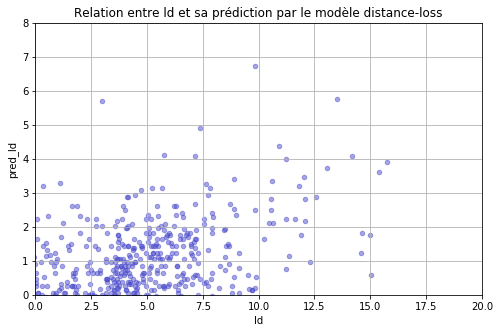

In [39]:
# prédictions
temp14['pred_ld'] = gamma * temp14['rssi'] + C
# scatterplot pour visualiser la relation
fig_4 = plt.figure(figsize=(8,5))
plt.scatter(temp14['ld'], temp14['pred_ld'], c=[[0.3,0.3,0.8]], alpha=0.5, s=20);
plt.xlim([0, 20])
plt.xlabel("ld")
plt.ylim([0, 8])
plt.ylabel("pred_ld")
plt.title('Relation entre ld et sa prédiction par le modèle distance-loss')
plt.grid(True)
plt.show()

On observe deux choses. Tout d'abord, il y a une claire relation linéaire et croissante entre les deux variables, impliquant que le modèle est correct dnas la relation modélisée. D'autre part, il apparaît clairement que la relation est assez lâche, impliquant que le modèle est significativement bruité. C'est une caractériqtique connue de ce modèle, qui est dommageable mais inévitable. Malgré tout, il semble intéressant de garder le feature $ld$ comme source d'information complémentaire pour les modèles à venir.

In [40]:
# on intègre le feature dans le set train_test
train_test['ld'] = gamma * train_test['rssi'] + C

In [41]:
train_test

messid       did  nseq        rssi       time_ux  \
9711   57849df012f143318207f0b7  476212.0   1.5 -138.000000  1.468309e+12   
19229  57cf9249cf554f22dcd6e486  476835.0   1.0 -125.000000  1.473221e+12   
19234  57cf9a1c12f1437531fda9c8  476835.0   1.0 -130.666667  1.473223e+12   
19231  57cf977be541cd01b3cc66bd  476835.0   1.0 -130.333333  1.473223e+12   
19230  57cf94df12f1437531fa1871  476835.0   1.0 -127.666667  1.473222e+12   
...                         ...       ...   ...         ...           ...   
12302  579f76db12f14345916e5154  473902.0   1.0 -135.666667  1.470068e+12   
28670  5843e9a6cf554f422f2b7495  472066.0   1.0 -127.500000  1.480846e+12   
14669  57cbfbbfcf554f22dc736cb2  472066.0   1.0 -111.333333  1.472986e+12   
14989  57cfe9e9e541cd01b30fe633  472066.0   1.0 -113.666667  1.473244e+12   
14667  57cbf92412f1437531983238  472066.0   1.0 -118.333333  1.472985e+12   

          bs_lat      bs_lng        lat         lng  new_bsid        ld  
9711   36.053394 -102.011461  35.770683 -102.094289         1 -7.802468  
19229  36.187012 -102.208966  36.089562 -102.313746         2 -5.246729  
19234  36.187012 -102.208966  36.064303 -102.278110         2 -6.360769  
19231  36.187012 -102.208966  36.072726 -102.286895         2 -6.295237  
19230  36.187012 -102.208966  36.079944 -102.298687         2 -5.770983  
...          ...         ...        ...         ...       ...       ...  
12302  42.850670 -107.463146  43.139786 -107.629761       242 -7.343746  
28670  48.072889 -110.957181   0.000000    0.000000       243 -5.738217  
14669  48.072889 -110.957181   0.000000    0.000000       243 -2.559926  
14989  48.072889 -110.957181   0.000000    0.000000       243 -3.018648  
14667  48.072889 -110.957181   0.000000    0.000000       243 -3.936093  

[68358 rows x 11 columns]

### Création de la matrice de features

On peut finalement créer la matrice de features. Pour cela, il est utile de déterminer au préalable le nombre de messid différents, et le nombre de stations distinctes.

In [42]:
# liste des messid dans train_test
messid = np.unique(train_test['messid'])
print("Il y a " + str(messid.shape[0]) + " messid différents en tout dans train_test.")
# liste des messid et did train dans train_test
temp13 = train_test[train_test['messid'].isin(messid_train)]
messid_train_list = temp13['messid'].drop_duplicates().values.tolist()
messid_did_train_list = temp13[['messid','did']].drop_duplicates().values.tolist()
print("Cela comprend " + str(len(messid_train_list)) + " messid différents dans la partie train du dataset.") 
# liste des messid et did test dans train_test
temp14 = train_test[train_test['messid'].isin(messid_test)]
messid_test_list = temp14['messid'].drop_duplicates().values.tolist()
messid_did_test_list = temp14[['messid','did']].drop_duplicates().values.tolist()
print("Cela comprend " + str(len(messid_test_list)) + " messid différents dans la partie test du dataset.")
print()
# liste des stations train dans train_test
temp15 = train_test[train_test['messid'].isin(messid_train)]
bsid_train_list = np.unique(temp15['new_bsid'])
print("Il y a " + str(len(bsid_train_list)) + " bsid différents dans la partie train du dataset.")

Il y a 11314 messid différents en tout dans train_test.
Cela comprend 6020 messid différents dans la partie train du dataset.
Cela comprend 5294 messid différents dans la partie test du dataset.

Il y a 236 bsid différents dans la partie train du dataset.


On va donc créer deux matrices de features: une pour l'échantillon train, et une pour l'échantillon test. La matrice train comprendra 6020 lignes (une pour chaque messid), et la matrice test comprendra 5294 lignes. Concernant les colonnes, c'est-à-dire les features, on gardera les variables d'intérêt du dataset, à savoir la puissance de signal rssi, la mesure de proximité ld, et la localisation de station bs_lat et bs_lng. On notera que pour un messid donné, plusieurs stations peuvent être concernées, ce qui amènera une stratégie de one-hot-encoding pour pouvoir inclure sur une seule ligne toute l'information relative à un messid donné. Autrement dit, pour chaque feature qui peut dépendre d'une station, on créera 236 features avec one-hot encoding, un pour chaque bsid différent du set train.

On enlèvera du set les variables qui ne semblent pas pertinentes pour prédire la éolocalisation. did sera enlevé, car c'est une variable qui fournit uniquement une étiquette, sans interpretation quantitative. time_ux sera ignoré car il contient des informations relatives au temps, ce qui n'ai de pas à prédire la géolocalisation. Une fois la matrice formée, messid sera enlevé également car il ne contient pas d'information autre qu'une étiquette. nseq est la variable la plus délicate: on ne sait pas ce qu'elle signifie. Elle contient possiblement de l'information utile, mais elle peut aussi contenir une information sans intérêt pour la géolocalisation, auquel cas elle ajoutera uniquement du bruit au modèle. Dans la mesure où son rôle est incertain, il semble préférable de ne pas l'inclure.

On ajoutera enfin d'autres variables d'intérêt au modèle. En particulier, cinq variables semblent intéressantes. D'abord, les rssi, ld, lattitude et longitude médians des stations qui ont été atteintes par un messid donné. Cela présente deux intérêts. D'abord, cela permet d'obtenir une première approximation géographique de la localisation du device émetteur du message. Ensuite, cela permet de ne pas perdre l'information contenue dans rssi, ld, bs_lat et bs_lng si une station de l'échantillon test n'a jamais été vue dans l'échantillon train au cours de l'entraînement. La dernière feature d'intérêt est le nombre total de stations qui ont reçu le message. Cette feature est utile car elle permet au modèle de déterminer si le device se trouve dans une zone à forte concentration de stations, ou plutot dans une zone où les messages sont captés par peu de stations.

On commence par créer les matrices $X_{train}$ et $X_{test}$ vides, qu'on remplira après.

In [43]:
# création de dataframes vides
X_train = pd.DataFrame(messid_did_train_list, columns = ['messid','did']).set_index('messid')
X_test = pd.DataFrame(messid_did_test_list, columns = ['messid','did']).set_index('messid')
X_train.head(5)

did
messid                            
57849df012f143318207f0b7  476212.0
57cf9249cf554f22dcd6e486  476835.0
57cf9a1c12f1437531fda9c8  476835.0
57cf977be541cd01b3cc66bd  476835.0
57cf94df12f1437531fa1871  476835.0

On va maintenant créer les colonnes de rssi. On va procéder par one-hot-encoding, c'est-à-dire qu'on va créer une feature pour chaque station présente dans l'échantillon train. Pour un messid donné, chaque station atteinte par le messid considéré va se voir attribuer la valeur correspondante de rssi. La question se pose de comment coder les stations qui n'ont pas été atteintes par le messid. Une possibilité consiste à choisir la valeur de rssi minimale sur toutes les observations, afin de refléter la plus grande distance observée sur l'échantillon:

In [44]:
train_test.describe()

did          nseq          rssi       time_ux        bs_lat  \
count  6.835800e+04  68358.000000  68358.000000  6.835800e+04  68358.000000   
mean   4.526511e+05      1.043382   -125.791992  1.472919e+12     39.780628   
std    1.210273e+05      0.584389      9.072470  5.358313e+09      0.185283   
min    1.103350e+05      0.000000   -155.000000  1.463542e+12     36.053394   
25%    4.725040e+05      1.000000   -132.000000  1.468261e+12     39.743521   
50%    4.739530e+05      1.000000   -127.000000  1.473228e+12     39.777690   
75%    4.763270e+05      1.500000   -121.000000  1.477600e+12     39.805696   
max    1.747448e+06      2.000000    -63.000000  1.481143e+12     48.072889   

             bs_lng           lat           lng      new_bsid            ld  
count  68358.000000  68358.000000  68358.000000  68358.000000  68358.000000  
mean    -105.059186     22.739342    -60.048048    120.353375     -5.402431  
std        0.149529     19.687563     51.987688     40.291283      1.783605  
min     -110.957181      0.000000   -107.630679      1.000000    -11.144589  
25%     -105.074287      0.000000   -105.048417     93.000000     -6.622896  
50%     -105.044371     39.699363   -104.991511    124.000000     -5.639919  
75%     -105.016392     39.783895      0.000000    149.000000     -4.460347  
max     -102.011461     43.140387      0.000000    243.000000      6.942182

Comme on peut le voir, cette valeur minimale de rssi est ici de -155. Une autre possibilité, suggérée par la litérature (N. Patwari, “Location estimation in sensor networks,” Ph.D. dissertation, University of Michigan, 2005.), consiste à utiliser la valeur unique de -200 pour refléter un signal trop faible pour être perçu. On retiendra ici une option intermédiaire, en fixant la valeur de rssi des stations non atteintes à -160.

In [45]:
# on boucle sur les bs_id du train
for bsid in bsid_train_list:
    # on rajoute une colonne avec valeur par défaut de -160, qu'on modifiera par la suite
    X_train['rssi_'+str(bsid)] = -160
    
# on boucle maintenant sur les messid du train
for messid in messid_train_list:
    # on restreint le dataset aux entrées de ce messid
    temp16 = train_test[train_test['messid']==messid]
    # liste de tous les bsid de ce messid
    bsid_temp_list = temp16['new_bsid'].drop_duplicates().values.tolist()
    # on boucle sur ces id
    for bsid in bsid_temp_list:
        # on remplace la valeur correspondante dans le dataframe
        X_train.loc[messid,'rssi_'+str(bsid)] = temp16[temp16['new_bsid']==bsid]['rssi'].values[0]

On procède de même pour la variable ld. Celle-ci reflète la proximité entre le device et la station qui a capté son signal, par inférence du rssi. Un plus haut score de ld reflète une plus grande proximité. La question se pose à nouveau de la valeur des stations non atteintes par le signal. On choisit une stratégie similaire à rssi: comme la valeur minimale du dataset est de -11.14, on fixe à -13 le score de toutes les stations qui n'ont pas été atteintes.

In [46]:
# on boucle sur les bs_id du train
for bsid in bsid_train_list:
    # on rajoute une colonne avec valeur par défaut de -13, qu'on modifiera par la suite
    X_train['ld_'+str(bsid)] = -13
    
# on boucle maintenant sur les messid du train
for messid in messid_train_list:
    # on restreint le dataset aux entrées de ce messid
    temp17 = train_test[train_test['messid']==messid]
    # liste de tous les bsid de ce messid
    bsid_temp_list = temp17['new_bsid'].drop_duplicates().values.tolist()
    # on boucle sur ces id
    for bsid in bsid_temp_list:
        # on remplace la valeur correspondante dans le dataframe
        X_train.loc[messid,'ld_'+str(bsid)] = temp17[temp17['new_bsid']==bsid]['ld'].values[0]

On procède aussi de même pour les variable bs_lat et bs_lng. Ici on peut choisir une valeur de 0 pour les stations non atteintes, car ainsi leur coordonnées seront simplement ignorées.

In [47]:
# on boucle sur les bs_id du train
for bsid in bsid_train_list:
    # on rajoute une colonne avec valeur par défaut de 0, qu'on modifiera par la suite
    X_train['bs_lat_'+str(bsid)] = 0
    
# on boucle maintenant sur les messid du train
for messid in messid_train_list:
    # on restreint le dataset aux entrées de ce messid
    temp18 = train_test[train_test['messid']==messid]
    # liste de tous les bsid de ce messid
    bsid_temp_list = temp18['new_bsid'].drop_duplicates().values.tolist()
    # on boucle sur ces id
    for bsid in bsid_temp_list:
        # on remplace la valeur correspondante dans le dataframe
        X_train.loc[messid,'bs_lat_'+str(bsid)] = temp18[temp18['new_bsid']==bsid]['bs_lat'].values[0]
          
# on boucle sur les bs_id du train
for bsid in bsid_train_list:
    # on rajoute une colonne avec valeur par défaut de 0, qu'on modifiera par la suite
    X_train['bs_lng_'+str(bsid)] = 0
    
# on boucle maintenant sur les messid du train
for messid in messid_train_list:
    # on restreint le dataset aux entrées de ce messid
    temp19 = train_test[train_test['messid']==messid]
    # liste de tous les bsid de ce messid
    bsid_temp_list = temp19['new_bsid'].drop_duplicates().values.tolist()
    # on boucle sur ces id
    for bsid in bsid_temp_list:
        # on remplace la valeur correspondante dans le dataframe
        X_train.loc[messid,'bs_lng_'+str(bsid)] = temp19[temp19['new_bsid']==bsid]['bs_lng'].values[0]

Pour finir, on ajoute les cinq derniers features d'intérêt: le nombres de stations atteintes par le signal, ainsi que les latitude, longitude, rssi et ld médians de ces stations.

In [48]:
# on rajoute une colonne avec valeur par défaut de 0, qu'on modifiera par la suite
X_train['mdn_rssi'] = 0
# on rajoute une colonne avec valeur par défaut de 0, qu'on modifiera par la suite
X_train['mdn_ld'] = 0
# on rajoute une colonne avec valeur par défaut de 0, qu'on modifiera par la suite
X_train['mdn_lat'] = 0
# on rajoute une colonne avec valeur par défaut de 0, qu'on modifiera par la suite
X_train['mdn_lng'] = 0
# on rajoute une colonne avec valeur par défaut de 0, qu'on modifiera par la suite
X_train['nb_bs'] = 0


# on boucle maintenant sur les messid du train
for messid in messid_train_list:
    # on restreint le dataset aux entrées de ce messid
    temp20 = train_test[train_test['messid']==messid]
    # calcul du rssi médian
    median_rssi = temp20['rssi'].median()
    # calcul du ld median
    median_ld = temp20['ld'].median()
    # calcul de la latitude médiane
    median_bs_lat = temp20['bs_lat'].median()
    # calcul de la longitude médiane
    median_bs_lng = temp20['bs_lng'].median()
    # calcul du nombre total de stations atteintes par le signal
    nb_bs = temp20.shape[0]
    # on remplace les valeurs correspondantes dans le dataframe
    X_train.loc[messid,'mdn_rssi'] = median_rssi
    X_train.loc[messid,'mdn_ld'] = median_ld
    X_train.loc[messid,'mdn_lat'] = median_bs_lat
    X_train.loc[messid,'mdn_lng'] = median_bs_lng
    X_train.loc[messid,'nb_bs'] = nb_bs

On va finalement rajouter les deux colonnes qui correspondent aux variables déterminées par ces features: la latitude et longitude du signal.

In [49]:
# on rajoute une colonne avec valeur par défaut de 0, qu'on modifiera par la suite
X_train['lat'] = 0
# on rajoute une colonne avec valeur par défaut de 0, qu'on modifiera par la suite
X_train['lng'] = 0

# on boucle maintenant sur les messid du train
for messid in messid_train_list:
    # on restreint le dataset aux entrées de ce messid
    temp21 = train_test[train_test['messid']==messid]
    # on remplace les valeurs correspondantes dans le dataframe
    X_train.loc[messid,'lat'] = temp21['lat'].values[0]
    X_train.loc[messid,'lng'] = temp21['lng'].values[0]

In [42]:
# aperçu du dataset final
X_train.columns

Index(['did', 'rssi_1', 'rssi_2', 'rssi_3', 'rssi_4', 'rssi_5', 'rssi_7',
       'rssi_8', 'rssi_9', 'rssi_10',
       ...
       'bs_lng_240', 'bs_lng_241', 'bs_lng_242', 'mdn_rssi', 'mdn_ld',
       'mdn_lat', 'mdn_lng', 'nb_bs', 'lat', 'lng'],
      dtype='object', length=952)

In [43]:
X_train.describe()

did       rssi_1  ...          lat          lng
count  6.020000e+03  6020.000000  ...  6020.000000  6020.000000
mean   4.836280e+05  -159.996346  ...    39.804147  -105.073922
std    9.940053e+04     0.283547  ...     0.374206     0.289681
min    4.732880e+05  -160.000000  ...    35.770683  -107.630679
25%    4.741920e+05  -160.000000  ...    39.706951  -105.064843
50%    4.763250e+05  -160.000000  ...    39.776106  -105.042435
75%    4.765210e+05  -160.000000  ...    39.816892  -104.996081
max    1.747448e+06  -138.000000  ...    43.140387  -102.094289

[8 rows x 952 columns]

De la même manière, on va créer le test set.

In [50]:
# on boucle sur les bs_id du train
for bsid in bsid_train_list:
    # on rajoute une colonne avec valeur par défaut de -160, qu'on modifiera par la suite
    X_test['rssi_'+str(bsid)] = -160
for bsid in bsid_train_list:
    # on rajoute une colonne avec valeur par défaut de -13, qu'on modifiera par la suite
    X_test['ld_'+str(bsid)] = -13
for bsid in bsid_train_list:
    # on rajoute une colonne avec valeur par défaut de 0, qu'on modifiera par la suite
    X_test['bs_lat_'+str(bsid)] = 0
# on boucle sur les bs_id du train
for bsid in bsid_train_list:
    # on rajoute une colonne avec valeur par défaut de 0, qu'on modifiera par la suite
    X_test['bs_lng_'+str(bsid)] = 0    
# on rajoute une colonne avec valeur par défaut de 0, qu'on modifiera par la suite
X_test['mdn_rssi'] = 0
# on rajoute une colonne avec valeur par défaut de 0, qu'on modifiera par la suite
X_test['mdn_ld'] = 0
# on rajoute une colonne avec valeur par défaut de 0, qu'on modifiera par la suite
X_test['mdn_lat'] = 0
# on rajoute une colonne avec valeur par défaut de 0, qu'on modifiera par la suite
X_test['mdn_lng'] = 0
# on rajoute une colonne avec valeur par défaut de 0, qu'on modifiera par la suite
X_test['nb_bs'] = 0
      
# on boucle maintenant sur les messid du test
for messid in messid_test_list:
    # on restreint le dataset aux entrées de ce messid
    temp22 = train_test[train_test['messid']==messid]
    # calcul du rssi médian
    median_rssi = temp22['rssi'].median()
    # calcul du ld median
    median_ld = temp22['ld'].median()
    # calcul de la latitude médiane
    median_bs_lat = temp22['bs_lat'].median()
    # calcul de la longitude médiane
    median_bs_lng = temp22['bs_lng'].median()
    # calcul du nombre total de stations atteintes par le signal
    nb_bs = temp22.shape[0]
    # on remplace les valeurs correspondantes dans le dataframe
    X_test.loc[messid,'mdn_rssi'] = median_rssi
    X_test.loc[messid,'mdn_ld'] = median_ld
    X_test.loc[messid,'mdn_lat'] = median_bs_lat
    X_test.loc[messid,'mdn_lng'] = median_bs_lng
    X_test.loc[messid,'nb_bs'] = nb_bs
    # liste de tous les bsid de ce messid qui ont été vues dans le train
    bsid_temp_list = temp22[temp22['new_bsid'].isin(bsid_train_list)]['new_bsid'].drop_duplicates().values.tolist()
    # on boucle sur ces id
    for bsid in bsid_temp_list:
        # on remplace la valeur correspondante dans le dataframe
        X_test.loc[messid,'rssi_'+str(bsid)] = temp22[temp22['new_bsid']==bsid]['rssi'].values[0]
        X_test.loc[messid,'ld_'+str(bsid)] = temp22[temp22['new_bsid']==bsid]['ld'].values[0]
        X_test.loc[messid,'bs_lat_'+str(bsid)] = temp22[temp22['new_bsid']==bsid]['bs_lat'].values[0]
        X_test.loc[messid,'bs_lng_'+str(bsid)] = temp22[temp22['new_bsid']==bsid]['bs_lng'].values[0]
        

In [51]:
# aperçu du dataset final
X_test

did  rssi_1  rssi_2  rssi_3  rssi_4  rssi_5  \
messid                                                                       
57d82ffee541cd01b3a6c819  473056.0    -160    -160    -160  -128.0    -160   
57a9deb8cf554f465ad24845  473281.0    -160    -160    -160  -134.0    -160   
57aa1bbd12f14345915f6d11  473281.0    -160    -160    -160  -160.0    -160   
57aa1e70cf554f465afe838e  473281.0    -160    -160    -160  -160.0    -160   
57aa1d1812f1434591604c90  473281.0    -160    -160    -160  -160.0    -160   
...                            ...     ...     ...     ...     ...     ...   
57bee85de541cd77a0b625ba  472854.0    -160    -160    -160  -160.0    -160   
574af9fb864fce1a9a82d9d1  116519.0    -160    -160    -160  -160.0    -160   
57e5704112f1437531c09dbc  472293.0    -160    -160    -160  -160.0    -160   
5799b15112f1434245b7f132  473231.0    -160    -160    -160  -160.0    -160   
57cfe9e9e541cd01b30fe633  472066.0    -160    -160    -160  -160.0    -160   

                          rssi_7  rssi_8  rssi_9  rssi_10  ...  bs_lng_238  \
messid                                                     ...               
57d82ffee541cd01b3a6c819    -160    -160    -160     -160  ...    0.000000   
57a9deb8cf554f465ad24845    -160    -160    -160     -160  ...    0.000000   
57aa1bbd12f14345915f6d11    -160    -160    -160     -160  ...    0.000000   
57aa1e70cf554f465afe838e    -160    -160    -160     -160  ...    0.000000   
57aa1d1812f1434591604c90    -160    -160    -160     -160  ...    0.000000   
...                          ...     ...     ...      ...  ...         ...   
57bee85de541cd77a0b625ba    -160    -160    -160     -160  ...    0.000000   
574af9fb864fce1a9a82d9d1    -160    -160    -160     -160  ...    0.000000   
57e5704112f1437531c09dbc    -160    -160    -160     -160  ...    0.000000   
5799b15112f1434245b7f132    -160    -160    -160     -160  ... -107.164831   
57cfe9e9e541cd01b30fe633    -160    -160    -160     -160  ...    0.000000   

                          bs_lng_239  bs_lng_240  bs_lng_241  bs_lng_242  \
messid                                                                     
57d82ffee541cd01b3a6c819           0           0           0           0   
57a9deb8cf554f465ad24845           0           0           0           0   
57aa1bbd12f14345915f6d11           0           0           0           0   
57aa1e70cf554f465afe838e           0           0           0           0   
57aa1d1812f1434591604c90           0           0           0           0   
...                              ...         ...         ...         ...   
57bee85de541cd77a0b625ba           0           0           0           0   
574af9fb864fce1a9a82d9d1           0           0           0           0   
57e5704112f1437531c09dbc           0           0           0           0   
5799b15112f1434245b7f132           0           0           0           0   
57cfe9e9e541cd01b30fe633           0           0           0           0   

                            mdn_rssi    mdn_ld    mdn_lat     mdn_lng  nb_bs  
messid                                                                        
57d82ffee541cd01b3a6c819 -128.000000 -5.836515  36.528704 -102.631195      1  
57a9deb8cf554f465ad24845 -134.000000 -7.016087  36.528704 -102.631195      1  
57aa1bbd12f14345915f6d11 -139.000000 -7.999063  36.785088 -102.737426      1  
57aa1e70cf554f465afe838e -136.000000 -7.409277  36.785088 -102.737426      1  
57aa1d1812f1434591604c90 -138.000000 -7.802468  36.785088 -102.737426      1  
...                              ...       ...        ...         ...    ...  
57bee85de541cd77a0b625ba -139.500000 -8.097361  41.938516 -106.547933      1  
574af9fb864fce1a9a82d9d1 -135.666667 -7.343746  41.938516 -106.547933      1  
57e5704112f1437531c09dbc -128.500000 -5.934812  41.938516 -106.547933      1  
5799b15112f1434245b7f132 -138.000000 -7.802468  42.205284 -107.164831      1  
57cfe9e9e541cd01b30fe633 -113.666667 -3.018648  48.072889 -110.9

In [52]:
X_test.describe()

did  rssi_1  rssi_2  rssi_3       rssi_4  rssi_5  rssi_7  \
count    5294.000000  5294.0  5294.0  5294.0  5294.000000  5294.0  5294.0   
mean   398615.102569  -160.0  -160.0  -160.0  -159.989044  -160.0  -160.0   
std    144505.191519     0.0     0.0     0.0     0.566621     0.0     0.0   
min    110335.000000  -160.0  -160.0  -160.0  -160.000000  -160.0  -160.0   
25%    472395.000000  -160.0  -160.0  -160.0  -160.000000  -160.0  -160.0   
50%    472504.000000  -160.0  -160.0  -160.0  -160.000000  -160.0  -160.0   
75%    472533.000000  -160.0  -160.0  -160.0  -160.000000  -160.0  -160.0   
max    473287.000000  -160.0  -160.0  -160.0  -128.000000  -160.0  -160.0   

       rssi_8  rssi_9  rssi_10  ...   bs_lng_238  bs_lng_239  bs_lng_240  \
count  5294.0  5294.0   5294.0  ...  5294.000000      5294.0      5294.0   
mean   -160.0  -160.0   -160.0  ...    -0.020243         0.0         0.0   
std       0.0     0.0      0.0  ...     1.472856         0.0         0.0   
min    -160.0  -160.0   -160.0  ...  -107.164831         0.0         0.0   
25%    -160.0  -160.0   -160.0  ...     0.000000         0.0         0.0   
50%    -160.0  -160.0   -160.0  ...     0.000000         0.0         0.0   
75%    -160.0  -160.0   -160.0  ...     0.000000         0.0         0.0   
max    -160.0  -160.0   -160.0  ...     0.000000         0.0         0.0   

       bs_lng_241  bs_lng_242     mdn_rssi       mdn_ld      mdn_lat  \
count      5294.0      5294.0  5294.000000  5294.000000  5294.000000   
mean          0.0         0.0  -125.352837    -5.316095    39.746760   
std           0.0         0.0     7.005166     1.377183     0.275952   
min           0.0         0.0  -142.000000    -8.588849    36.528704   
25%           0.0         0.0  -130.000000    -6.229705    39.716317   
50%           0.0         0.0  -126.500000    -5.541622    39.757890   
75%           0.0         0.0  -122.666667    -4.788006    39.787201   
max           0.0         0.0   -63.000000     6.942182    48.072889   

           mdn_lng        nb_bs  
count  5294.000000  5294.000000  
mean   -105.049334     5.531923  
std       0.209716     6.308375  
min    -110.957181     1.000000  
25%    -105.074287     2.000000  
50%    -105.043755     3.000000  
75%    -105.022820     7.000000  
max    -102.631195    64.000000  

[8 rows x 950 columns]

## Fonction distance

Nous reprenons les fonctions données dans l'exemple pour calculer les distances à partir de lat et lng

In [53]:
from geopy.distance import geodesic

In [54]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [geodesic(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [55]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

## Machine Learning

In [0]:
Xtrain_xgb = X_train.copy()

Après une première tentative de prédiction avec le X_train et le Y_Train tels que définis précédemment, nous n'avions de bons résultats. Notamment nous trouvions que la station située dans le Montana présente dans le X_test était associée à de mauvaises prédictions de localisations de mess_id.  

Nous avons donc opté pour une autre stratégie, nous allons faire en sorte que nos modèles prédisent un écart à la longitude et à la latitude médiane des stations qui reçoivent le message que l'on souhaite géolocaliser.  

Commme notre modèle va donc désormais être relatif à une position médiane, nous retirons les variables liées à la médiane dans le X_train et le X_test.

In [0]:
Ytrain_xgb = pd.DataFrame(columns=['lat_rel','lng_rel'])
Ytrain_xgb['lat_rel'] = Xtrain_xgb['lat']-Xtrain_xgb['mdn_lat']
Ytrain_xgb['lng_rel'] = Xtrain_xgb['lng']-Xtrain_xgb['mdn_lng']

In [0]:
Xtrain_xgb = Xtrain_xgb.drop(columns = ['did','nb_bs','mdn_rssi','mdn_lat','mdn_lng','mdn_ld','lat','lng'])

In [0]:
Xtest_xgb = X_test.copy()

In [0]:
Xtest_xgb = Xtest_xgb.drop(columns = ['did','nb_bs','mdn_rssi','mdn_lat','mdn_lng','mdn_ld'])

### Gridsearch

Nous nous sommes rendus compte que le 'Leave One-Device Out' est très chronophage. Nous avons donc optés pour la stratégie suivante afin de sélectionner le meilleur modèle pour prédire la longitude et la latitude:  
On a d'abord sélecitonné 4 familles de modèle: GradientBoostingRegressor, RandomForest, ExtraTrees et LGBM.
Nous avons réalisé un Gridsearch 'classique' afin de trouver le meilleur modèle de chaque famille.  
Enfin, nous réalisons un 'Leave One-Device Out' pour sélectionner le meilleur modèle parmi ces quatres.

In [0]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import lightgbm as lgb

In [0]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Liste des hyperparamètres pour le GridSearchCV de chaque famille de modèle:
# Nous les avons faits tournés sur Google Collab

param_gbr = {'min_samples_leaf':[1,5,10] ,
             'learning_rate':[0.01, 0.05, 0.1],
             'n_estimators':[150,250,400],
             'max_features': [None, 'sqrt', 'log2'], 
             'max_depth':[7,10 ,100]}

param_rf = {'max_depth': [10,15,20,25,30],
            'max_features': [None, 'sqrt', 'log2'],
            'min_samples_leaf': [10, 15, 20],
            'min_samples_split': [10, 15, 20],
            'n_estimators': [600, 800, 1000]}

params_lgbm = {'boosting_type':['gbdt'], 
               'num_leaves':[30,50,90], 
               'max_depth':[15,25,35], 
               'learning_rate':[0.008,0.05, 0.1], 
               'n_estimators':[1000, 5000, 10000], 
               'Objective':['regression'], 
               'min_child_samples':[5,10,15,20], 
               'colsample_bytree':[0.5, 0.8], 
               'reg_lambda':[0.0, 0.01, 0.05], 
               'n_jobs':[-1]}

param_et = {'min_samples_leaf':[10,15,20,30], 
            'min_samples_split':[5,10,15],
            'max_depth':[15,25,35,45], 
            'n_estimators':[800, 1200, 1500]}

In [ ]:
GBR_lat_rel = GradientBoostingRegressor(verbose=3)
GS_lat_rel = GridSearchCV(estimator=GBR_lat_rel, param_grid= parameters,cv=5 ,scoring = 'neg_mean_squared_error',n_jobs=-1, verbose=3)
GS_lat_rel.fit(Xtrain_xgb,Ytrain_xgb['lat_rel'])
print(GS_lat_rel.best_params_)

GBR_lng_rel = GradientBoostingRegressor(verbose=3)
GBR_lng_rel = GridSearchCV(estimator=GBR_lng_rel, param_grid= parameters,cv=5 ,scoring = 'neg_mean_squared_error',n_jobs=-1, verbose=3)
GBR_lng_rel.fit(Xtrain_xgb,Ytrain_xgb['lng_rel'])
print(GBR_lng_rel.best_params_)

In [ ]:
RF_lat_rel = RandomForestRegressor()
RF_lat_rel = GridSearchCV(estimator=RF_lat_rel, param_grid= param_rf, cv=5, scoring= 'neg_mean_squared_error',n_jobs=-1, verbose=3)
RF_lat_rel.fit(Xtrain_xgb,Ytrain_xgb['lat_rel'])
RF_lat_rel.best_params_

RF_lng_rel = RandomForestRegressor()
RF_lng_rel = GridSearchCV(estimator=RF_lng_rel, param_grid= param_rf,cv=5 ,scoring= 'neg_mean_squared_error',n_jobs=-1, verbose=3)
RF_lng_rel.fit(Xtrain_xgb,Ytrain_xgb['lng_rel'])
RF_lng_rel.best_params_

In [ ]:
LGBM_lat_rel = lgb.LGBMRegressor()
LGBM_lat_rel = GridSearchCV(estimator=LGBM_lat_rel, param_grid= params_lgbm, cv=3, scoring= 'neg_mean_squared_error',n_jobs=-1, verbose=3)
LGBM_lat_rel.fit(Xtrain_xgb,Ytrain_xgb['lat_rel'])
print(LGBM_lat_rel.best_params_)

LGBM_lng_rel = lgb.LGBMRegressor()
LGBM_lng_rel = GridSearchCV(estimator=LGBM_lng_rel, param_grid= params_lgbm,cv=3 ,scoring= 'neg_mean_squared_error',n_jobs=-1, verbose=3)
LGBM_lng_rel.fit(Xtrain_xgb,Ytrain_xgb['lng_rel'])
print(LGBM_lng_rel.best_params_)

In [ ]:
ET_lat_rel = ExtraTreesRegressor()
ET_lat_rel = GridSearchCV(estimator=ET_lat_rel, param_grid= param_et, cv=3, scoring= 'neg_mean_squared_error',n_jobs=-1, verbose=3)
ET_lat_rel.fit(Xtrain_xgb,Ytrain_xgb['lat_rel'])
print(ET_lat_rel.best_params_)

ET_lng_rel = ExtraTreesRegressor()
ET_lng_rel = GridSearchCV(estimator=ET_lng_rel, param_grid= param_et,cv=3 ,scoring= 'neg_mean_squared_error',n_jobs=-1, verbose=3)
ET_lng_rel.fit(Xtrain_xgb,Ytrain_xgb['lng_rel'])
print(ET_lng_rel.best_params_)

### Leave One Device Out pour sélectionner parmi les 4 meilleurs modèles

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneGroupOut

In [ ]:
# Création des Folds pour le Leave One Device Out
groups = X_train['did']
logo = LeaveOneGroupOut()
cvlol = logo.split(Xtrain_xgb, Ytrain_xgb, groups)

Nous paramétrons les modèles avec les meilleurs hyperparamètres trouvés dans la phase précédente, et nous comparons leurs erreurs avec le Leave One-Device Out:

In [73]:
#Latitude
cvlol = logo.split(Xtrain_xgb, Ytrain_xgb, groups)
GBR_lat_rel = GradientBoostingRegressor(learning_rate = 0.01, max_depth = 100, max_features = 'log2', min_samples_leaf = 10, n_estimators = 250)
print("GradientBoostingRegressor: ")
mse_gbr = cross_val_score(GBR_lat_rel, Xtrain_xgb, Ytrain_xgb['lat_rel'], scoring='neg_mean_squared_error', cv = cvlol, n_jobs = -1, verbose =3).mean()
print("MSE GradientBoostingRegressor: " , mse_gbr)

GradientBoostingRegressor: 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of 113 | elapsed:   14.7s remaining:    8.3s


MSE GradientBoostingRegressor:  -0.0015112539192056746


[Parallel(n_jobs=-1)]: Done 110 out of 113 | elapsed:   20.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:   20.1s finished


In [74]:
cvlol = logo.split(Xtrain_xgb, Ytrain_xgb, groups)
RFR_lat_rel = RandomForestRegressor(max_depth=30,max_features='sqrt',min_samples_leaf=10,min_samples_split=20,n_estimators=1000)
print("RandomForestRegressor: ")
mse_rfr = cross_val_score(RFR_lat_rel, Xtrain_xgb, Ytrain_xgb['lat_rel'], scoring='neg_mean_squared_error', cv = cvlol, n_jobs = -1,verbose =3).mean()
print("MSE RandomForestRegressor: " , mse_rfr)

RandomForestRegressor: 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of 113 | elapsed:  1.1min remaining:   36.4s
[Parallel(n_jobs=-1)]: Done 110 out of 113 | elapsed:  1.6min remaining:    2.5s


MSE RandomForestRegressor:  -0.0015029624765867371


[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:  1.6min finished


In [75]:
cvlol = logo.split(Xtrain_xgb, Ytrain_xgb, groups)
lgb_lat_rel = lgb.LGBMRegressor(Objective = 'regression', boosting_type='gbdt', colsample_bytree=0.8, learning_rate=0.008, max_depth=15, min_child_samples=10, n_estimators= 1000, n_jobs= -1, num_leaves=50, reg_lambda=0.0)
print("Light Gradient Boosting: ")
mse_lgb = cross_val_score(lgb_lat_rel, Xtrain_xgb, Ytrain_xgb['lat_rel'], scoring='neg_mean_squared_error', cv = cvlol, n_jobs = -1,verbose =3).mean()
print("MSE Light Gradient Boosting: " , mse_lgb)

Light Gradient Boosting: 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  72 out of 113 | elapsed:  1.7min remaining:   59.4s
[Parallel(n_jobs=-1)]: Done 110 out of 113 | elapsed:  2.4min remaining:    3.9s


MSE Light Gradient Boosting:  -0.0015850262087402194


[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:  2.4min finished


In [78]:
cvlol = logo.split(Xtrain_xgb, Ytrain_xgb, groups)
ETR_lat_rel = ExtraTreesRegressor(max_depth = 25, min_samples_leaf = 10, min_samples_split = 5, n_estimators = 800)
print("ExtraTreesRegressor: ")
mse_etr = cross_val_score(ETR_lat_rel, Xtrain_xgb, Ytrain_xgb['lat_rel'], scoring='neg_mean_squared_error', cv = cvlol, n_jobs = -1,verbose =3).mean()
print("MSE ExtraTreesRegressor: " , mse_etr)

ExtraTreesRegressor: 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of 113 | elapsed: 16.1min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done 110 out of 113 | elapsed: 23.5min remaining:   38.4s


MSE ExtraTreesRegressor:  -0.001630836472510213


[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed: 23.5min finished


In [79]:
#Longitude
cvlol = logo.split(Xtrain_xgb, Ytrain_xgb, groups)
GBR_lng_rel = GradientBoostingRegressor(learning_rate = 0.01, max_depth = 100, max_features = 'sqrt', min_samples_leaf = 10, n_estimators = 400)
print("GradientBoostingRegressor: ")
mse_gbr = cross_val_score(GBR_lng_rel, Xtrain_xgb, Ytrain_xgb['lng_rel'], scoring='neg_mean_squared_error', cv = cvlol, n_jobs = -1).mean()
print("MSE GradientBoostingRegressor: " , mse_gbr)

GradientBoostingRegressor: 
MSE GradientBoostingRegressor:  -0.00138542518585912


In [80]:
cvlol = logo.split(Xtrain_xgb, Ytrain_xgb, groups)
RFR_lng_rel = RandomForestRegressor(max_depth=30,max_features=None, min_samples_leaf=15, min_samples_split=20,n_estimators=600)
print("RandomForestRegressor: ")
mse_rfr = cross_val_score(RFR_lng_rel, Xtrain_xgb, Ytrain_xgb['lng_rel'], scoring='neg_mean_squared_error', cv = cvlol, n_jobs = -1).mean()
print("MSE RandomForestRegressor: " , mse_rfr)

RandomForestRegressor: 
MSE RandomForestRegressor:  -0.0015110385739806847


In [82]:
cvlol = logo.split(Xtrain_xgb, Ytrain_xgb, groups)
lgb_lng_rel = lgb.LGBMRegressor(Objective = 'regression', boosting_type='gbdt', colsample_bytree=0.8, learning_rate=0.008, max_depth=15, min_child_samples=10, n_estimators= 1000, n_jobs= -1, num_leaves=50, reg_lambda=0.0)
print("Light Gradient Boosting: ")
mse_lgb = cross_val_score(lgb_lng_rel, Xtrain_xgb, Ytrain_xgb['lng_rel'], scoring='neg_mean_squared_error', cv = cvlol, n_jobs = -1,verbose =3).mean()
print("MSE Light Gradient Boosting: " , mse_lgb)

MSE Light Gradient Boosting:  -0.0013836280528667917


In [83]:
cvlol = logo.split(Xtrain_xgb, Ytrain_xgb, groups)
ETR_lng_rel = ExtraTreesRegressor(max_depth = 25, min_samples_leaf=20, min_samples_split=15, n_estimators=1200)
print("ExtraTreesRegressor: ")
mse_etr = cross_val_score(ETR_lng_rel, Xtrain_xgb, Ytrain_xgb['lng_rel'], scoring='neg_mean_squared_error', cv = cvlol, n_jobs = -1,verbose =3).mean()
print("MSE ExtraTreesRegressor: " , mse_etr)

ExtraTreesRegressor: 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of 113 | elapsed: 23.5min remaining: 13.4min
[Parallel(n_jobs=-1)]: Done 110 out of 113 | elapsed: 34.3min remaining:   56.0s


MSE ExtraTreesRegressor:  -0.0015146150004041743


[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed: 34.4min finished


**Meilleurs modèles en latitude et longitude**  
La vue des MSE permet de sélectionner le Random Forest pour la prédiction de la latitude, et le LGBM pour la prédicton de la longitude.

In [84]:
RFR_lat_rel.fit(Xtrain_xgb.to_numpy(), Ytrain_xgb['lat_rel'].values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [85]:
lgb_lng_rel.fit(Xtrain_xgb.to_numpy(), Ytrain_xgb['lng_rel'].values.ravel())

LGBMRegressor(Objective='regression', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.8, importance_type='split',
              learning_rate=0.008, max_depth=15, min_child_samples=10,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
              n_jobs=-1, num_leaves=50, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [0]:
y_pred_lat  = RFR_lat_rel.predict(Xtest_xgb)+X_test['mdn_lat']
y_pred_lng  = lgb_lng_rel.predict(Xtest_xgb)+X_test['mdn_lng']

In [0]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res['messid'] = X_test.reset_index()['messid']

In [0]:
test_res.to_csv('pred_pos_test_list.csv', index=False)

In [89]:
test_res.head()

lat         lng                    messid
0  36.520255 -102.626999  57d82ffee541cd01b3a6c819
1  36.520255 -102.626999  57a9deb8cf554f465ad24845
2  36.776638 -102.733230  57aa1bbd12f14345915f6d11
3  36.776638 -102.733230  57aa1e70cf554f465afe838e
4  36.776638 -102.733230  57aa1d1812f1434591604c90

In [57]:
test_res = pd.read_csv('pred_pos_test_list.csv')

In [60]:
import plotly.express as px

In [61]:
# Prédiction de la position des messages test
fig = px.scatter_mapbox(test_res, lat="lat", lon="lng", zoom=3, height=600,color_discrete_sequence=["fuchsia"]) #
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [62]:
# Stations test initiales
fig = px.scatter_mapbox(test, lat="bs_lat", lon="bs_lng", zoom=3, height=600,color_discrete_sequence=["blue"]) #
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
err_vec = Eval_geoloc(X_train['lat'] , X_train['lng'], RFR_lat_rel.predict(Xtrain_xgb)+X_train['mdn_lat'], lgb_lng_rel.predict(Xtrain_xgb)+X_train['mdn_lng'])

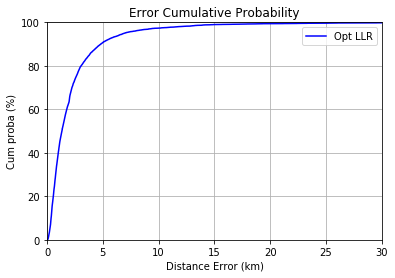

In [93]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

In [94]:
np.percentile(err_vec, 80)

3044.5950707282677

Avec les modèles choisis pour prédire la latitude et la longitude des messages, nous avons une erreur de 3044.6 mètres à 80%.